# Use DeepCCA along with MCA and OPNMF to transform ADNI features

## Importing Stuff:

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler
from DeepCCAModels import DeepCCA
from main import Solver
from utils import load_data, svm_classify
from objectives import cca_loss
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pprint

## Read the Data:

The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl".

The transformed through FAMD data is located at "./DATA/FAMD_Transformed_data_10_components.pkl"

In [51]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [52]:
mca_data = np.load("./DATA/MCA_Transformed_Genetic_data_10_components.pkl.npy")
print(mca_data.shape)
print(mca_data)

(1302, 10)
[[ 0.02371735  0.00758166  0.03124097 ...  0.02007631 -0.03371415
   0.02345717]
 [ 0.01051906 -0.02912091 -0.02414146 ... -0.03836163  0.01941386
   0.05144005]
 [ 0.00313658  0.02024018  0.03054364 ... -0.01525235 -0.01290234
   0.03417399]
 ...
 [-0.00580048  0.00667212  0.03939653 ...  0.01200354  0.00510257
  -0.04572104]
 [ 0.06722299 -0.00955109 -0.08351047 ...  0.02180382  0.01885345
  -0.038522  ]
 [ 0.03114945  0.02050712  0.03119218 ...  0.01215095 -0.03140962
   0.02663309]]


In [53]:
opnmf_coeffs = pd.read_csv("./DATA/loading_coefficients_30components.tsv", sep='\t')
print(opnmf_coeffs.shape)
opnmf_coeffs.head()

(1294, 33)


,participant_id,session_id,path,component_1,component_2,component_3,component_4,component_5,component_6,component_7,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
0,002_S_0295,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,912.99866,842.33325,831.71893,1042.49220,1083.90710,670.48160,784.81110,...,839.09924,619.7323,681.45100,832.0467,659.40180,598.43787,737.67930,849.0394,653.38510,529.58984
1,002_S_0413,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,823.07510,780.51350,770.62060,901.71234,917.71313,618.90840,828.32007,...,765.77704,861.1545,674.06160,755.7838,719.56067,937.99410,694.54680,825.4079,766.40090,773.84576
2,002_S_0559,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,896.78010,931.24915,1173.90540,911.99170,908.41504,749.03250,988.38477,...,1046.81020,843.5071,877.13410,885.0218,911.55505,906.45730,701.53510,894.4284,837.21240,713.27203
3,002_S_0619,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,872.89777,1011.12885,952.32367,1081.24560,1135.83150,764.39440,823.27960,...,857.98660,813.3923,913.79160,875.5856,1001.27344,827.59820,686.68600,651.2841,764.98206,742.52910
4,002_S_0729,ses-M0,/cbica/projects/ISTAGING/Pipelines/ISTAGING_Da...,799.76800,702.03735,825.50490,819.52435,871.45575,642.43066,679.25323,...,600.88570,702.8355,673.74255,764.6585,650.25160,685.98645,587.51636,666.1610,624.62510,647.47455


### Create the Dataset:

In [54]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
columns_to_drop = genetic_columns
print(lr_data.shape)
mca = lr_data.drop(labels = columns_to_drop, axis=1)

# Embed them into the new dataset:
genetic_component_labels = ["genetic_component_"+str(x+1) for x in range(mca_data.shape[1])] 
mca[genetic_component_labels] = mca_data
print(mca.shape)
mca.head()

(1302, 209)
(1302, 165)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,genetic_component_9,genetic_component_10
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


In [55]:
print("MCA Genetic + original Imaging: ",mca.shape)
print("OPNMF Imaging: ", opnmf_coeffs.shape)
mca = mca[mca['PTID'].isin(opnmf_coeffs['participant_id'])]
print("MCA Genetic + filtered Imaging: ", mca.shape)
mca.drop(labels=MRI_columns, axis=1, inplace=True)
imaging_component_labels = ["imaging_component_"+str(x+1) for x in range(30)] # OPNMF Number of Components instead of 30
mca[imaging_component_labels] = opnmf_coeffs.loc[:,"component_1":"component_30"]
print("MCA Genetic + OPNMF Imaging: ", mca.shape)
mca.reset_index(inplace=True)
mca.head()

MCA Genetic + original Imaging:  (1302, 165)
OPNMF Imaging:  (1294, 33)
MCA Genetic + filtered Imaging:  (1294, 165)
MCA Genetic + OPNMF Imaging:  (1294, 50)


,index,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,...,839.09924,619.73230,681.45100,832.04670,659.40180,598.43787,737.67930,849.03940,653.38510,529.58984
1,9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,...,862.20703,825.19970,696.64390,778.52200,674.44110,578.46576,703.68823,793.19147,721.19824,666.04390
2,24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,...,831.40780,807.35345,665.36320,697.93360,751.61566,906.69570,730.25250,791.89940,721.12305,654.74646
3,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,596.51337,631.54395,608.99243,882.18915,653.10596,624.51434,581.76410,691.03600,775.39860,656.84470
4,45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,...,1093.95310,1051.10690,938.05310,835.57513,826.75433,773.29144,973.11370,1082.61940,878.15530,733.94415


##  Building, training the DCCA Model

### Create the 2 views:

In [56]:
# View 1:
view_1 = mca.loc[:,"imaging_component_1":"imaging_component_30"]

# View 2:
view_2 = mca.loc[:,"genetic_component_"+str(1):"genetic_component_"+str(mca_data.shape[1])]

print("View 1:")
display(view_1.head())
print("View 2:")
display(view_2.head())

View 1:


,imaging_component_1,imaging_component_2,imaging_component_3,imaging_component_4,imaging_component_5,imaging_component_6,imaging_component_7,imaging_component_8,imaging_component_9,imaging_component_10,...,imaging_component_21,imaging_component_22,imaging_component_23,imaging_component_24,imaging_component_25,imaging_component_26,imaging_component_27,imaging_component_28,imaging_component_29,imaging_component_30
0,912.99866,842.33325,831.71893,1042.49220,1083.90710,670.48160,784.8111,784.8393,1107.99290,742.97406,...,839.09924,619.73230,681.45100,832.04670,659.40180,598.43787,737.67930,849.03940,653.38510,529.58984
1,877.81720,746.37020,979.36390,1023.07086,1095.75070,606.95306,652.3977,658.4550,1004.95636,751.94385,...,862.20703,825.19970,696.64390,778.52200,674.44110,578.46576,703.68823,793.19147,721.19824,666.04390
2,982.78815,820.89860,1108.92650,874.28820,932.25650,633.16520,940.1620,715.5377,892.65260,800.88810,...,831.40780,807.35345,665.36320,697.93360,751.61566,906.69570,730.25250,791.89940,721.12305,654.74646
3,731.74530,693.98390,764.74774,774.83220,768.90106,809.51965,813.9021,593.1962,959.14874,561.39990,...,596.51337,631.54395,608.99243,882.18915,653.10596,624.51434,581.76410,691.03600,775.39860,656.84470
4,997.74680,790.52814,1057.66960,955.03610,860.19430,752.22380,1180.3739,762.3138,928.96620,1026.41700,...,1093.95310,1051.10690,938.05310,835.57513,826.75433,773.29144,973.11370,1082.61940,878.15530,733.94415


View 2:


,genetic_component_1,genetic_component_2,genetic_component_3,genetic_component_4,genetic_component_5,genetic_component_6,genetic_component_7,genetic_component_8,genetic_component_9,genetic_component_10
0,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
1,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
2,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
3,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
4,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


### Parameters:

In [59]:
device = torch.device('cpu')
outdim_size = 150
input_shape1 = view_1.shape[1]
input_shape2 = view_2.shape[1]
layer_sizes1 = [256, 1024, 1024, outdim_size]
layer_sizes2 = [256, 1024, 1024, outdim_size]
learning_rate = 1e-4
epoch_num = 400
epoch_log_freq = 50
batch_size = 1000
reg_par = 1e-2
# the path to save the final learned features, as DCCA-o-d.
save_to = './DATA/ADNI_MCA_OPNMF_DCCA_features_'+str(outdim_size)+'_'+str(len(layer_sizes1)-1)+'.pkl'
use_all_singular_values = False
apply_linear_cca = True

### Training:

In [60]:
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, use_all_singular_values, device=device).double()
solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size, learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=True)

s_1, s_2 = data1.shape[0], data2.shape[0]
# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()

[ INFO : 2022-04-12 17:25:21,462 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=30, out_features=256, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (1): Linear(in_features=1024, out_features=150, bias=True)
       

(1294, 30) <class 'numpy.ndarray'> float64
(1294, 10) <class 'numpy.ndarray'> float64
torch.Size([1294, 30]) <class 'torch.Tensor'>
torch.Size([1294, 10]) <class 'torch.Tensor'>


[ INFO : 2022-04-12 17:25:21,765 ] - Epoch 1: val_loss improved from 0.0000 to -0.0047
[ INFO : 2022-04-12 17:25:21,765 ] - Epoch 1/400 - time: 0.30 - training_loss: -0.0047 - val_loss: -0.0047
[ INFO : 2022-04-12 17:25:35,585 ] - Epoch 51: val_loss did not improve from -0.0047
[ INFO : 2022-04-12 17:25:35,586 ] - Epoch 51/400 - time: 0.27 - training_loss: -0.0047 - val_loss: -0.0047
[ INFO : 2022-04-12 17:25:48,882 ] - Epoch 101: val_loss did not improve from -0.0047
[ INFO : 2022-04-12 17:25:48,883 ] - Epoch 101/400 - time: 0.26 - training_loss: -0.0047 - val_loss: -0.0047
[ INFO : 2022-04-12 17:26:02,188 ] - Epoch 151: val_loss did not improve from -0.0047
[ INFO : 2022-04-12 17:26:02,188 ] - Epoch 151/400 - time: 0.26 - training_loss: -0.0047 - val_loss: -0.0047
[ INFO : 2022-04-12 17:26:15,729 ] - Epoch 201: val_loss did not improve from -0.0047
[ INFO : 2022-04-12 17:26:15,729 ] - Epoch 201/400 - time: 0.34 - training_loss: -0.0047 - val_loss: -0.0047
[ INFO : 2022-04-12 17:26:31

LinAlgError: SVD did not converge

### Saving the model:

In [44]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

print()

print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

# Saving new features in a gzip pickled file specified by save_to
with open("DATA/MCA_OPNMF_DCCA_outputs.pkl", 'wb') as f:
    pickle.dump(outputs, f)

[-145.02   -95.084]

<class 'numpy.ndarray'>
(1302, 150)
<class 'numpy.ndarray'>
(1302, 150)


### Plotting the losses:

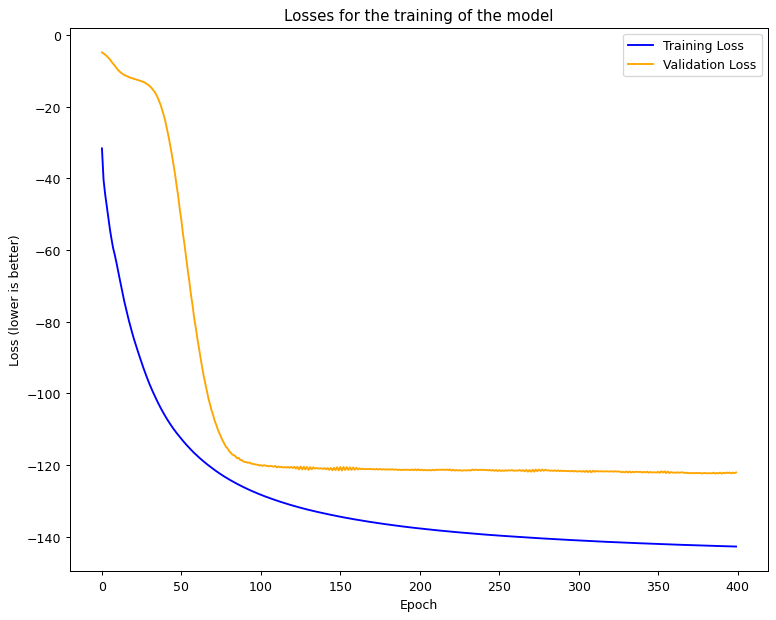

In [45]:
x = np.arange(len(training_losses))
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()

## Testing the model:

### Testing the Correlation between inputs and outputs of the deep Network:

In [49]:
from sklearn.cross_decomposition import CCA

print("CCA on input data:")
X = data1
Y = data2
cca = CCA(n_components=10)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
print(cca.score(X, Y))

print("CCA on output data:")
X = outputs[0]
Y = outputs[1]
cca = CCA(n_components=150,max_iter=10000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
# The best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse)
print(cca.score(X, Y)) 

CCA on input data:
0.059720376659286464
CCA on output data:
0.5119092606151266
